# Detecting Outliers using the rolling mean and median
Conda environment: `time-series`  
26 Feb 2024

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL

In [19]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [20]:
df = pd.read_csv("../datasets/example_retail_sales_with_outliers.csv",
                parse_dates=["ds"],
                index_col=["ds"])
df

,y
ds,
1992-01-01,"146,376.0000"
1992-02-01,"147,079.0000"
1992-03-01,"159,336.0000"
1992-04-01,"163,669.0000"
1992-05-01,"170,068.0000"
...,...
2004-12-01,"387,155.0000"
2005-01-01,"293,261.0000"
2005-02-01,"295,062.0000"


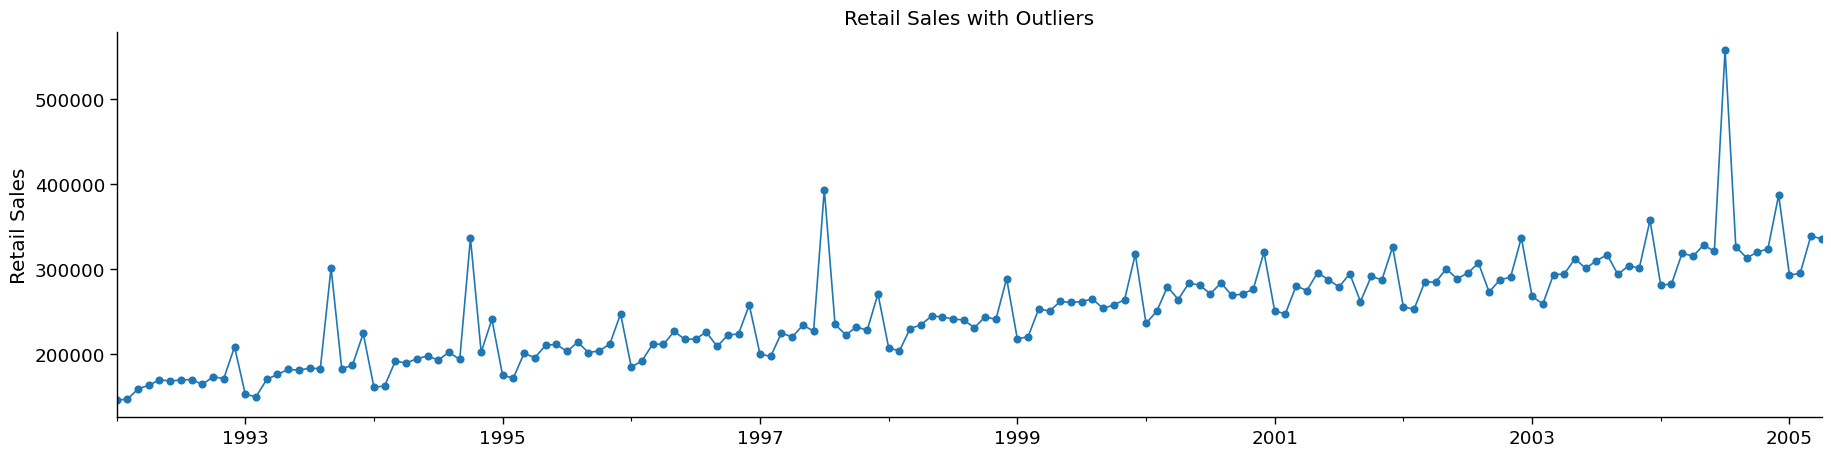

In [21]:
df.plot(marker="o", legend=None)

plt.title("Retail Sales with Outliers")
plt.ylabel("Retail Sales")
plt.xlabel("")
plt.show()

## 2) De-seasonalise data

In [22]:
# Apply STL decomposition
res = STL(df["y"], robust=True).fit()
seasonal_component = res.seasonal

# De-seasonalise data
df_deseasoned = (df["y"] - seasonal_component).to_frame("y")
df_deseasoned.head()

,y
ds,
1992-01-01,"164,493.4959"
1992-02-01,"166,194.1243"
1992-03-01,"164,808.7046"
1992-04-01,"164,603.4994"
1992-05-01,"167,157.1315"


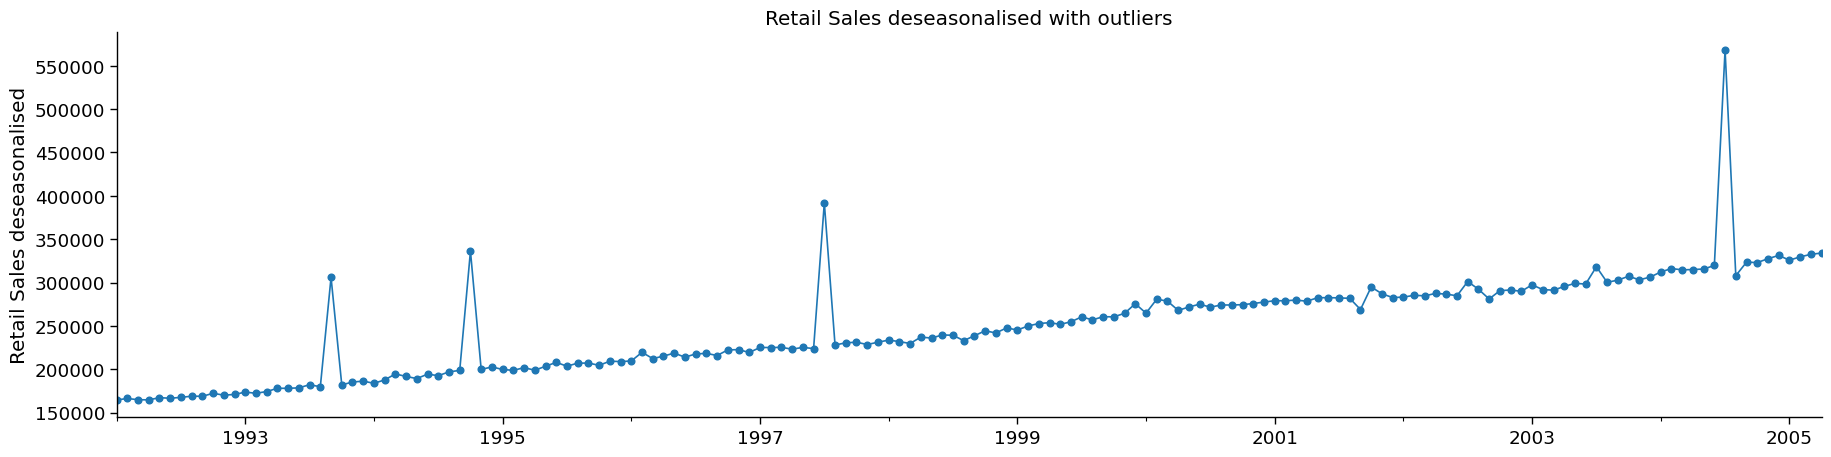

In [23]:
df_deseasoned.plot(marker="o", legend=None)

plt.title("Retail Sales deseasonalised with outliers")
plt.ylabel("Retail Sales deseasonalised")
plt.xlabel("")
plt.show()

## 3) Rolling mean
Parameters to obtain the expected value $\hat{y}_t$
* Window size: $2T+1$
* $\alpha$ = 3

In [24]:
df_ = df.copy(deep=True)

In [25]:
# Compute yhat using a rolling mean and the rolling standard deviation which will be used as part of the threshold
df_rolling_stats = (
    df_["y"]
    .rolling(
        window=13,  # A window of 13 is chosen to average over yearly seasonality
        center=True,  # Use a centered window for the mean
        min_periods=1,
    )  # Min periods set to 1 so that edge cases also have estimates
    .agg({"rolling_mean": "mean", "rolling_std": "std"})
)

# Rolling mean and std
df_[["rolling_mean", "rolling_std"]] = df_rolling_stats

# Apply the threshold criteria to identify an outlier
factor = 3
df_["is_outlier"] = np.abs(df_["y"] - df_["rolling_mean"]) > factor * df_["rolling_std"]

num_outliers = df_[df_["is_outlier"] == True].shape[0]

print(f"Num of Outliers detected by rolling mean: {num_outliers}")

# Add the upper and lower boundaries
df_["upper"] = df_["rolling_mean"] + factor * df_["rolling_std"]
df_["lower"] = df_["rolling_mean"] - factor * df_["rolling_std"]

df_.head()

Num of Outliers detected by rolling mean: 4


,y,rolling_mean,rolling_std,is_outlier,upper,lower
ds,,,,,,
1992-01-01,"146,376.0000","160,725.8571","10,303.7557",False,"191,637.1242","129,814.5901"
1992-02-01,"147,079.0000","161,930.6250","10,129.7748",False,"192,319.9493","131,541.3007"
1992-03-01,"159,336.0000","162,229.1111","9,517.7540",False,"190,782.3730","133,675.8492"
1992-04-01,"163,669.0000","163,371.7000","9,673.5433",False,"192,392.3300","134,351.0700"
1992-05-01,"170,068.0000","164,114.9091","9,502.4025",False,"192,622.1167","135,607.7015"


### 3.1) Plot rolling mean

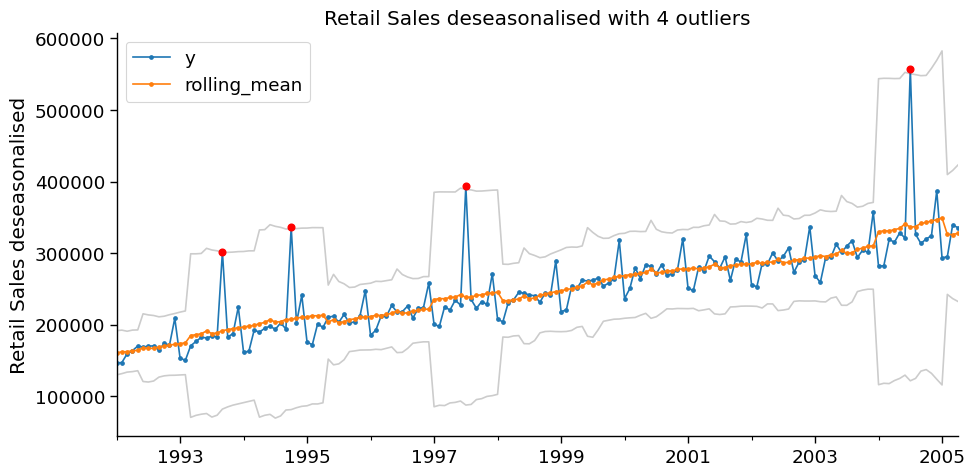

In [31]:
fig, ax = plt.subplots(figsize=[10, 5])

# Main plot
df_.plot(y=["y", "rolling_mean"], marker=".", ax=ax)
df_.plot(y=["upper", "lower"], figsize=[10, 5], ax=ax, color="k", alpha=0.2, legend=None)

# Plot outliers
if df_["is_outlier"].any():
    df_["y"].loc[df_["is_outlier"]].plot(marker="o", color="r", ax=ax, legend=None, linestyle="")

ax.set_title(f"Retail Sales deseasonalised with {num_outliers} outliers")
ax.set_ylabel("Retail Sales deseasonalised")
ax.set_xlabel("")
plt.tight_layout()

## 4) Rolling median
Parameters to obtain the expected value $\hat{y}_t$
* Window size: $2T+1$
* $\alpha$ = 3

In rolling median, we replace the following values:
* Mean -> Median (robust to outliers).
* Standard deviation (std) -> Median Absolute Deviation (MAD) which is also robust to outliers.

MAD can be defined as follow:

$$ MAD = median(|y - median(y)|) $$

$\alpha=3.5$ is a recommended choice [2], however this can be adjusted.

[2] Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and Handle Outliers", The ASQC Basic References in Quality Control: Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.

In [32]:
# MAD function
median_absolute_deviation = lambda y: np.median(np.abs(y - np.median(y)))

df_ = df_deseasoned.copy(deep=True)

In [38]:
# Compute median and MAD
df_rolling_stats = (
    df_["y"]
    .rolling(
        window=13,  # A window of 13 is chosen to average over yearly seasonality
        center=True,  # Use a centered window for the mean
        min_periods=1,
    )  # Min periods set to 1 so that edge cases also have estimates
    .agg({"rolling_median": "median", "rolling_MAD": median_absolute_deviation})
)
df_[["rolling_median", "rolling_MAD"]] = df_rolling_stats

# Apply the threshold criteria to identify an outlier
factor = 3.5
df_["is_outlier"] = (np.abs(df_["y"] - df_["rolling_median"]) > factor * df_["rolling_MAD"])

# Compute the upper and lower boundary of the threshold for plotting
df_["upper"] = df_["rolling_median"] + factor * df_["rolling_MAD"]
df_["lower"] = df_["rolling_median"] - factor * df_["rolling_MAD"]

# Num of outliers
num_outliers = df_[df_["is_outlier"] == True].shape[0]
print(f"Num of Outliers detected by rolling median: {num_outliers}")

df_.head()

Num of Outliers detected by rolling median: 8


,y,rolling_median,rolling_MAD,is_outlier,upper,lower
ds,,,,,,
1992-01-01,"164,493.4959","166,194.1243","1,302.9374",False,"170,754.4050","161,633.8435"
1992-02-01,"166,194.1243","166,336.2413","1,344.1785",False,"171,040.8660","161,631.6166"
1992-03-01,"164,808.7046","166,478.3583","1,669.6537",False,"172,322.1463","160,634.5704"
1992-04-01,"164,603.4994","166,817.7449","1,967.7366",False,"173,704.8230","159,930.6668"
1992-05-01,"167,157.1315","167,157.1315","1,702.8721",False,"173,117.1839","161,197.0792"


### 4.1) Plot rolling median

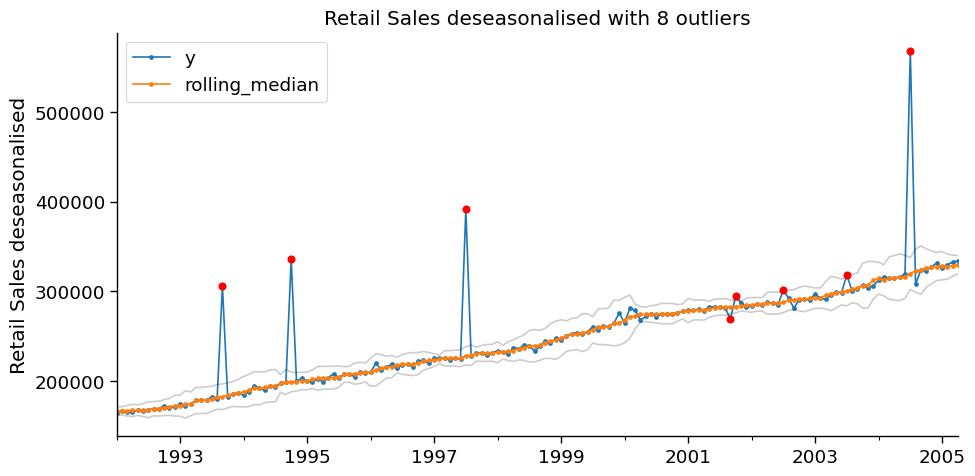

In [43]:
fig, ax = plt.subplots(figsize=[10, 5])

# Main plot
df_.plot(y=["y", "rolling_median"], marker=".", ax=ax)
df_.plot(y=["upper", "lower"], figsize=[10, 5], ax=ax, color="k", alpha=0.2, legend=None)

# Plot outliers
if df_["is_outlier"].any():
    df_["y"].loc[df_["is_outlier"]].plot(marker="o", color="r", ax=ax, legend=None, linestyle="")

ax.set_title(f"Retail Sales deseasonalised with {num_outliers} outliers")
ax.set_ylabel("Retail Sales deseasonalised")
ax.set_xlabel("")
plt.tight_layout()

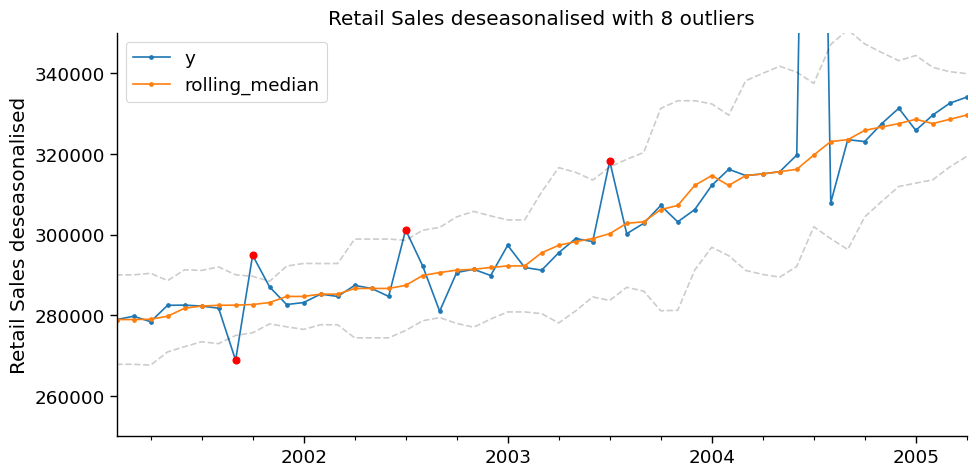

In [61]:
# Let's zoom in and see what's happening with non-obvious outliers
mask = (df_.index > '2001')
df_masked = df_[mask]

fig, ax = plt.subplots(figsize= (10,5))

# Plot 1
df_masked.plot(y=["y", "rolling_median"], marker=".", ax=ax)
df_masked.plot(y=["upper", "lower"], figsize=[10, 5], ax=ax, color="k", alpha=0.2, legend=None, linestyle="dashed")

# Highlight residuals
if df_["is_outlier"].any():
    df_masked["y"].loc[df_masked["is_outlier"]].plot(marker="o", color="r", ax=ax, legend=None, linestyle="")

ax.set_title(f"Retail Sales deseasonalised with {num_outliers} outliers")
ax.set_ylabel("Retail Sales deseasonalised")
ax.set_xlabel("")
ax.set_ylim([250000, 350000])
plt.tight_layout()

## 5) Removing Outliers

In [62]:
# Set outliers to NaN
df_.loc[df_["is_outlier"], "y"] = np.NaN

# Apply linear interpolation
df_.interpolate(method="linear", inplace=True)

# Add the seasonality extracted from STL back to deseasoned data
df_["y"] = df_["y"] + res.seasonal

df_.head()

,y,rolling_median,rolling_MAD,is_outlier,upper,lower
ds,,,,,,
1992-01-01,"146,376.0000","166,194.1243","1,302.9374",False,"170,754.4050","161,633.8435"
1992-02-01,"147,079.0000","166,336.2413","1,344.1785",False,"171,040.8660","161,631.6166"
1992-03-01,"159,336.0000","166,478.3583","1,669.6537",False,"172,322.1463","160,634.5704"
1992-04-01,"163,669.0000","166,817.7449","1,967.7366",False,"173,704.8230","159,930.6668"
1992-05-01,"170,068.0000","167,157.1315","1,702.8721",False,"173,117.1839","161,197.0792"


### 5.1) Plot before and after imputation

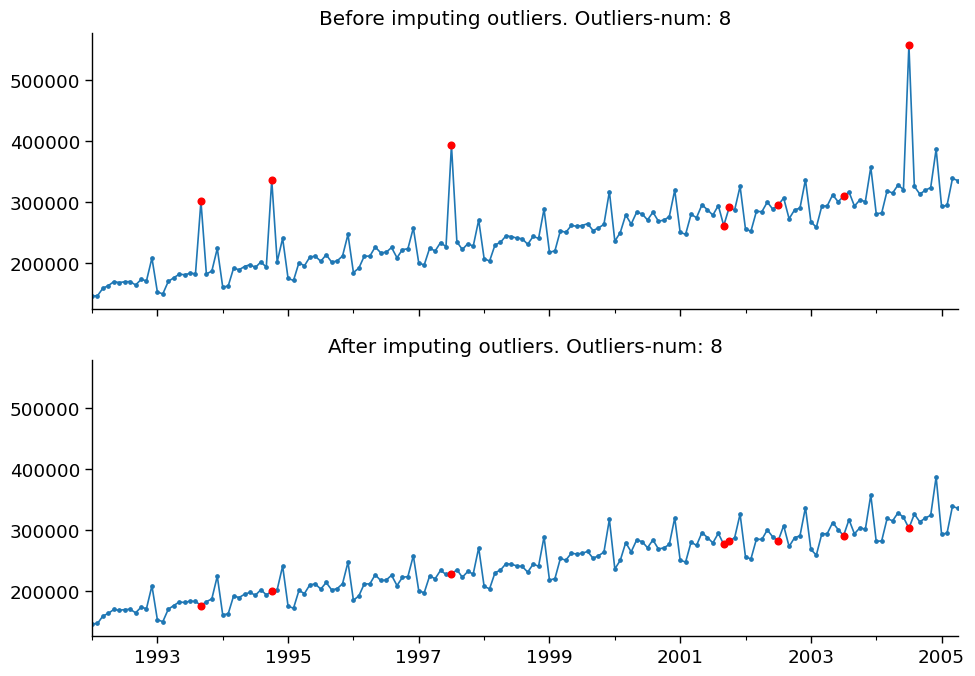

In [69]:
fig, ax = plt.subplots(nrows=2, figsize=[10, 7], sharex=True, sharey=True)

# Plot 1
df.plot(y="y", marker=".", title=f"Before imputing outliers. Outliers-num: {num_outliers}", ax=ax[0], legend=None)
df[df_["is_outlier"]]["y"].plot(marker="o", color="r", ax=ax[0], legend=None, linestyle="")

# Plot 2
df_.plot(y=["y"], marker=".", title=f"After imputing outliers. Outliers-num: {num_outliers}", ax=ax[1], legend=None)
df_[df_["is_outlier"]]["y"].plot(marker="o", color="r", ax=ax[1], legend=None, linestyle="")

ax[1].set_xlabel("")
plt.tight_layout()